In [83]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns

# Problem Statement

In Reinforcement Learning(RL), an agent(or algorithm) learns by the method of trial and error.
One of the hard parts of Reinforcement Learning is to model the environment and how agent interacts with it. Once we have a model for this, we can start generating data for learning as the agent interacts with the environment and starts gathering the rewards. The goal of learning is to maximize the rewards in the long term.

OpenAI gym library is basically the UCI for Reinforcement learning problems.
https://gym.openai.com/docs/

It provides simulation models for a number of environments where we can apply RL.

We will consider the taxi problem for this demo  
https://gym.openai.com/envs/Taxi-v3/

In [95]:
env = gym.make('Taxi-v3')
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



* The above visual shows an area which has been divided into 5x5 grid
* There is a self driving taxi (indicated by yellow mark when empty and green mark when passenger has occupied it).
* The goal for self driving taxi is to pick up the passenger from one of the 4 locations and drop off to another location

In [96]:
from gym.envs.toy_text.taxi import TaxiEnv
print(TaxiEnv.__doc__)


    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

    Observations: 
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y

# How do we solve this problem using Reinforcement Learning?

Lets set the terminology right  

Environment: 5x5 space in which the taxi ferries the passenger from pickup to drop location (universe in which the agent performs action and learns)  
Agent: Taxi (learner)  
Action: Taxi moves 1 grid east/west/north/south or picks/drops passenger  
State: One of the 500 possible states of the environment with a specific position of taxi and passenger  
Reward: -1 for each action, +20 for correct drop off, -10 for incorrect drop-off 

RL - Solve the problem of maximizing the reward in the long term

Lets use the Q-learning algorithm to solve this problem

In [97]:
# There are 500 possible states and 6 possible actions
print(env.env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


## Lets drive step by step to better understand the environment

In [98]:
# B(Blue) is the passenger location
# R(magenta) is the destination
# Taxi is indicated by yellow
env.env.s = 492
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [99]:
#Move West
env.step(3)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


In [100]:
#pick up the passenger
env.step(4)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)


In [101]:
#start towards destination

In [102]:
env.step(1)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)


In [103]:
# Fast forward to destination

env.step(1)
env.step(3)
env.step(3)
env.step(3)
env.step(1)
env.step(1)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


In [104]:
# Drop off (Taxi becomes yellow)
env.step(5)
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


## Lets try to solve the problem by brute force

In [105]:
reward = 0
total_reward = 0
steps = 0
env.reset()
while reward!=20:
    action = env.env.action_space.sample() # Determine a random action
    _, reward, _, _ = env.step(action) # Perform the action
    total_reward += reward # Accumulate reward
    steps+=1 # Count the steps
print(steps, total_reward)

13136 -51212


# Solve the problem using q-learning

Q-learning is similar to Dynamic Programming. 
(Both are based on Bellman's equation. In Dynamic programming, the idea is to simply store the results of subproblems, so that we do not have to re-compute them when needed later. E.g. Finding factorial for a number)

In Q-learning, we learn the Q-table, which is a matrix of expected rewards for state transition based on a certain action.
Each row represents state of the model  
Each columns represents an action  
Each cell represents expected reward when a certain action is performed  

![Image](https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686)

In [106]:
#Initialize Q table with zeros
Q = np.zeros((env.env.observation_space.n, env.action_space.n))
print(Q.shape)
actions = "South North East West Pickup Dropoff".split()
pd.DataFrame(Q, columns = actions)

(500, 6)


,South,North,East,West,Pickup,Dropoff
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
alpha = 0.7 #learning rate
gamma = 0.8 #discount factor
episodes = 1000
Q = np.zeros((env.env.observation_space.n, env.action_space.n))

learning = {}
for episode in range(episodes):
    cur_state = env.reset()
    reward = 0
    total_reward = 0
    done = False
    while not done:
        #action = env.env.action_space.sample()
        action = np.argmax(Q[cur_state])
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        Q[cur_state][action] += alpha*(reward + gamma*(np.max(Q[next_state]) - Q[cur_state][action]))
        cur_state = next_state
    learning[episode] = total_reward
    if episode % 100 == 0:
        print(total_reward)

-524
-88
-76
14
5
1
5
10
6
11


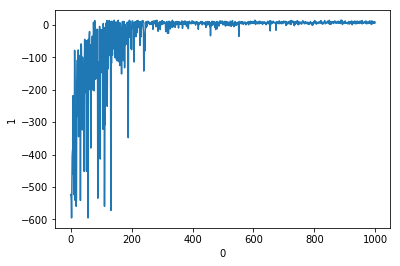

In [108]:
# Learning curve
sns.lineplot(x = 0, y = 1, data = pd.DataFrame(learning.items()))

Most of the learning is completed by ~ 400 episodes

In [109]:
# Q table after training
pd.DataFrame(Q, columns = actions)

,South,North,East,West,Pickup,Dropoff
0,0.000000,0.000000,0.000000,0.000000,0.00,0.0
1,-7.552651,-7.000000,-6.903858,-7.000000,13.75,-7.0
2,-3.511544,-3.500000,-3.447908,-3.500000,18.75,-7.0
3,-6.206110,-6.300000,-6.817890,-6.300000,15.00,-7.0
4,-12.804649,-13.300000,-13.357784,-13.300000,-14.00,-14.0
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.00,0.0
496,-6.300000,-6.224872,-6.300000,-6.168029,-7.00,-7.0
497,-3.500000,-3.152936,-3.500000,-3.137851,-7.00,-7.0
498,-5.600000,-1.417172,-5.600000,-6.059126,-7.00,-7.0


In [110]:
# Lets traverse the path based on q-learning solution
reward = 0
total_reward = 0
steps = 0
s = env.reset()
env.render()
done = False
while not done:
    action = np.argmax(Q[s])
    s, reward, done, _ = env.step(action)
    env.render()
    total_reward += reward
    steps+=1
print(steps, total_reward)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |


# Other algorithms to explore

### SARSA: Epsilon-greedy Q-learning

### DQN: Deep Q-Network
* Q table is replaced by a neural network which represents a Q function
* Can be used to predict action for unseen states unlike Q table 

### DDPG (Deep Deterministic Policy Gradient):
*  Used for very large action spaces

## Taxonomy of RL Algorithms:  
* Model Based vs. Model Free (You do not need to know all the states of environment upfront)  
https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#a-taxonomy-of-rl-algorithms

# Further Reading
https://spinningup.openai.com/en/latest/index.html
http://incompleteideas.net/book/bookdraft2017nov5.pdf